<a href="https://colab.research.google.com/github/pawelszajwaj/Segregation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobranie z githuba plików audio

In [1]:
!git clone https://github.com/pawelszajwaj/Segregation.git

Cloning into 'Segregation'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 328 (delta 16), reused 135 (delta 2), pack-reused 146
Receiving objects: 100% (328/328), 229.81 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (35/35), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
import tensorflow as tf
import os

In [4]:
!pip install tensorflow-io
import tensorflow_io as tfio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 30.5 MB/s eta 0:00:00


In [5]:
!mkdir AudioFiles
!mkdir AudioFiles/Good
!mkdir AudioFiles/Bad

In [6]:
!unzip '/content/Segregation/AudioFiles/Good/*.zip' -d '/content/AudioFiles/Good'
!unzip '/content/Segregation/AudioFiles/Bad/*.zip' -d '/content/AudioFiles/Bad'
if os.path.exists("/content/AudioFiles/Bad/13.1.21.wav"):
  os.remove("/content/AudioFiles/Bad/13.1.21.wav")

Archive:  /content/Segregation/AudioFiles/Good/3_seconds_good_1-5.zip
  inflating: /content/AudioFiles/Good/5.1.20.wav  
  inflating: /content/AudioFiles/Good/1.1.1.wav  
  inflating: /content/AudioFiles/Good/1.1.2.wav  
  inflating: /content/AudioFiles/Good/1.1.3.wav  
  inflating: /content/AudioFiles/Good/1.1.4.wav  
  inflating: /content/AudioFiles/Good/1.1.5.wav  
  inflating: /content/AudioFiles/Good/1.1.6.wav  
  inflating: /content/AudioFiles/Good/1.1.7.wav  
  inflating: /content/AudioFiles/Good/1.1.8.wav  
  inflating: /content/AudioFiles/Good/1.1.9.wav  
  inflating: /content/AudioFiles/Good/1.1.10.wav  
  inflating: /content/AudioFiles/Good/1.1.11.wav  
  inflating: /content/AudioFiles/Good/1.1.12.wav  
  inflating: /content/AudioFiles/Good/1.1.13.wav  
  inflating: /content/AudioFiles/Good/1.1.14.wav  
  inflating: /content/AudioFiles/Good/1.1.15.wav  
  inflating: /content/AudioFiles/Good/1.1.16.wav  
  inflating: /content/AudioFiles/Good/1.1.17.wav  
  inflating: /content

In [7]:
audio_files = glob('/content/AudioFiles/*/*.wav')
audio_files_good = glob('/content/AudioFiles/Good/*.wav')
audio_files_bad = glob('/content/AudioFiles/Bad/*.wav')

In [8]:
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

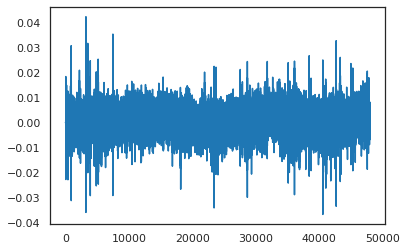

In [9]:
wav = load_wav_16k_mono(audio_files_bad[0])
wav = load_wav_16k_mono(audio_files_good[0])
plt.plot(wav.numpy())

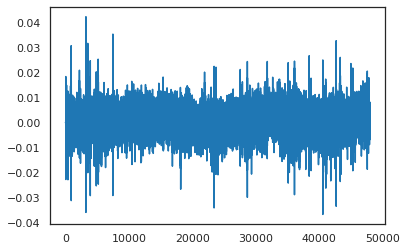

In [10]:
wav = tf.cast(wav, tf.float32)
plt.figure()
plt.plot(wav.numpy())

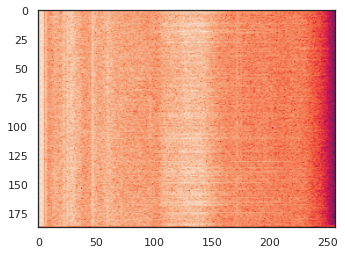

In [11]:
spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

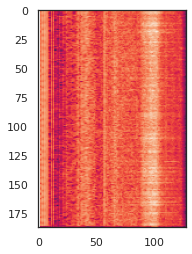

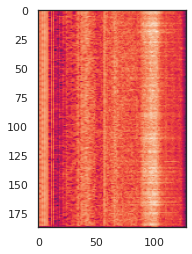

In [12]:
mel_spectrogram = tfio.audio.melscale(
  spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
dbscale_mel_spectrogram = tfio.audio.dbscale(
  mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [13]:
good = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.wav')
bad = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.wav')
good.as_numpy_iterator().next()

b'/content/AudioFiles/Good/1.1.8.wav'

In [14]:
positives = tf.data.Dataset.zip((good, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((bad, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
data = positives.concatenate(negatives)
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFiles/Bad/23.1.14.wav', 0.0)

In [15]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = tf.cast(wav, tf.float32)
  spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
  return dbscale_mel_spectrogram, label

In [16]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
print(len(data))
train = data.take(16)
test = data.skip(16).take(8)

26


In [18]:
samples, labels = train.as_numpy_iterator().next()

In [20]:
samples.shape

(16, 188, 128, 1)

In [19]:
labels

array([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

In [22]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(188, 128, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 186, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 184, 124, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 365056)            0         
                                                                 
 dense (Dense)               (None, 128)               46727296  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 46,729,905
Trainable params: 46,729,905
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
16/16 [==============================] - 34s 2s/step - loss: 242.2246 - recall: 0.6183 - precision: 0.6000 - val_loss: 65.6181 - val_recall: 1.0000 - val_precision: 0.6545
Epoch 2/4
16/16 [==============================] - 18s 1s/step - loss: 17.8540 - recall: 0.7131 - precision: 0.7250 - val_loss: 2.0728 - val_recall: 0.5645 - val_precision: 1.0000
Epoch 3/4
16/16 [==============================] - 20s 1s/step - loss: 0.2406 - recall: 0.9612 - precision: 0.9538 - val_loss: 0.2108 - val_recall: 1.0000 - val_precision: 0.8592
Epoch 4/4
16/16 [==============================] - 18s 1s/step - loss: 0.0887 - recall: 0.9516 - precision: 0.9833 - val_loss: 0.0086 - val_recall: 1.0000 - val_precision: 1.0000


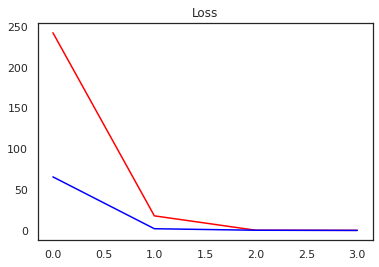

In [26]:
plt.title("Loss")
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

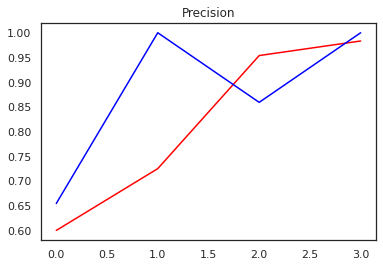

In [30]:
plt.title("Precision")
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

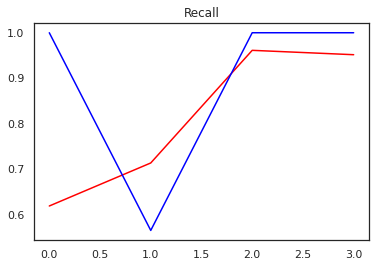

In [31]:
plt.title("Recall")
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

In [32]:
# WIELKI TEST
X_test, y_test = test.as_numpy_iterator().next()

In [33]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 509ms/step


In [34]:
yhat

array([[0.0000000e+00],
       [0.0000000e+00],
       [2.6958137e-06],
       [8.7579108e-09],
       [0.0000000e+00],
       [5.1643472e-08],
       [9.9994957e-01],
       [6.5847519e-07],
       [4.7596447e-30],
       [1.4055936e-34],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.2202205e-04],
       [9.9997753e-01],
       [9.8577964e-01]], dtype=float32)

In [35]:
y_test  ## ewidentnie przetretnowany

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

# Tu sprawdzimy, czy inny podział ma sens. 

Podzielimy dane na 2 rodzaje danych:
 - pierwsza grupa to te ewidetnie złe vs reszta 
 - druga to to srednie vs te dobre. 
 
Podział zostanie przeprowadzony zgodnie z przyjetymi zalozeniami, tj. 1-10 dobre, 11-23 złe


In [45]:
var_good_data = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.wav')
var_mid_data1 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/11*.wav')
var_mid_data2 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/12*.wav')
var_mid_data3 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/15*.wav')
var_mid_data4 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/17*.wav')
var_mid_data5 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/18*.wav')
var_mid_data6 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/19*.wav')
var_mid_data7 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/20*.wav')
var_mid_data8 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/22*.wav')
var_bad_data1 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/13*.wav')
var_bad_data2 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/14*.wav')
var_bad_data3 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/16*.wav')
var_bad_data4 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/21*.wav')
var_bad_data5 = tf.data.Dataset.list_files('/content/AudioFiles/Bad/23*.wav')

In [ ]:
var_mid_data1 = var_mid_data1.load

In [47]:
print(len(var_mid_data1))
print(len(var_bad_data1))
print(len(var_good_data))

20
20
203
